# Imports

In [1]:
import inspect
import logging
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np

import torch
import torch.nn
import torch.optim
import torch.utils.data

from IPython.display import clear_output, display, HTML

# Parameters

In [2]:
n_points = 5
n_samples = 1000

# Dataset

## `NumpyToTensorDataset`

In [3]:
class NumpyToTensorDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: torch.utils.data.Dataset):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        if isinstance(data, tuple):
            data = tuple(
                torch.tensor(item, dtype=torch.float32) if isinstance(item, np.ndarray) else item
                for item in data
            )
        else:
            data = torch.tensor(data, dtype=torch.float32)
        return data

## `MultiplicationDataset`

In [4]:
class MultiplicationDataset(torch.utils.data.Dataset):
    def __init__(self, n_points=100, length=10, training=True):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if isinstance(idx, int):
            if idx < 0:
                idx += len(self)
            if idx < 0 or idx >= len(self):
                raise IndexError("Index out of range")
            return self.generate_sample()
        elif isinstance(idx, slice):
            return self.generate_samples(self._slice_length(idx))
        elif isinstance(idx, list) or isinstance(idx, torch.Tensor):
            return self.generate_samples(len(idx))
        else:
            raise TypeError("Index should be an integer, slice, list, or tensor.")

    def _slice_length(self, slice_obj):
        start, stop, step = slice_obj.indices(len(self))
        if step > 0:
            return max(0, (stop - start + (step - 1)) // step)
        elif step < 0:
            return max(0, (start - stop - (step + 1)) // -step)
        else:
            raise ValueError("slice step cannot be zero")
    
    def get_parameters(self, size):
        if self.training:
            a = np.random.uniform(low=-5, high=5, size=size)
            b = np.random.uniform(low=-5, high=5, size=size)
        else:
            a = np.random.uniform(low=-10, high=10, size=size)
            b = np.random.uniform(low=-10, high=10, size=size)
        return np.hstack( (a,b) ), a*b
            
    def generate_sample(self):
        return self.get_parameters(size=self.n_points)

    def generate_samples(self, count):
        return self.get_parameters(size=(count,self.n_points))

## Data Visualization

### Targets

xx: (10, 10)
yy: (10, 5)
xa: (10, 5)
xb: (10, 5)


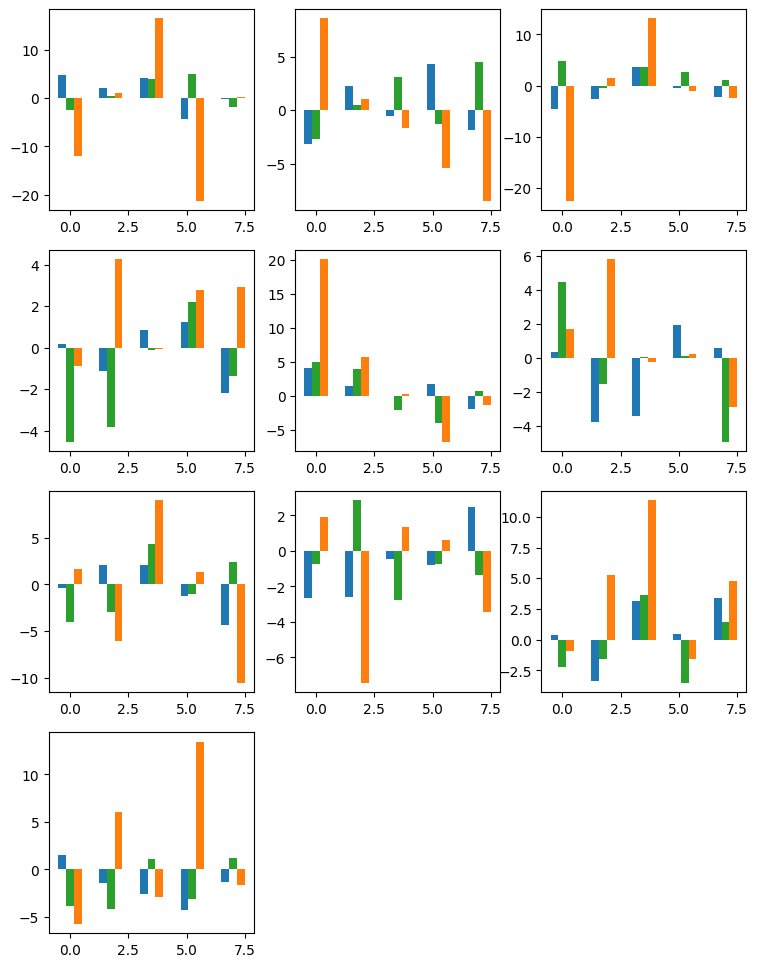

In [5]:
xx,yy = MultiplicationDataset(n_points=n_points, length=10, training=True)[:]
xa,xb = xx[:,:n_points], xx[:,n_points:]

print(f"xx: {xx.shape}")
print(f"yy: {yy.shape}")
print(f"xa: {xa.shape}")
print(f"xb: {xb.shape}")

indices = np.arange(n_points) * 1.75
width = 1/3

n_cols = 3
n_rows = int( np.ceil(len(yy)/n_cols) )
fig = plt.figure(figsize=(n_cols*3, n_rows*3))
gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)

for ii in range(len(yy)):
    ax = fig.add_subplot(gs[ii])
    ax.bar(indices - width, xa[ii], width=width, color="tab:blue",   label="A")
    ax.bar(indices,         xb[ii], width=width, color="tab:green",  label="B")
    ax.bar(indices + width, yy[ii], width=width, color="tab:orange", label="C")
plt.show()

### Parameter Distribution

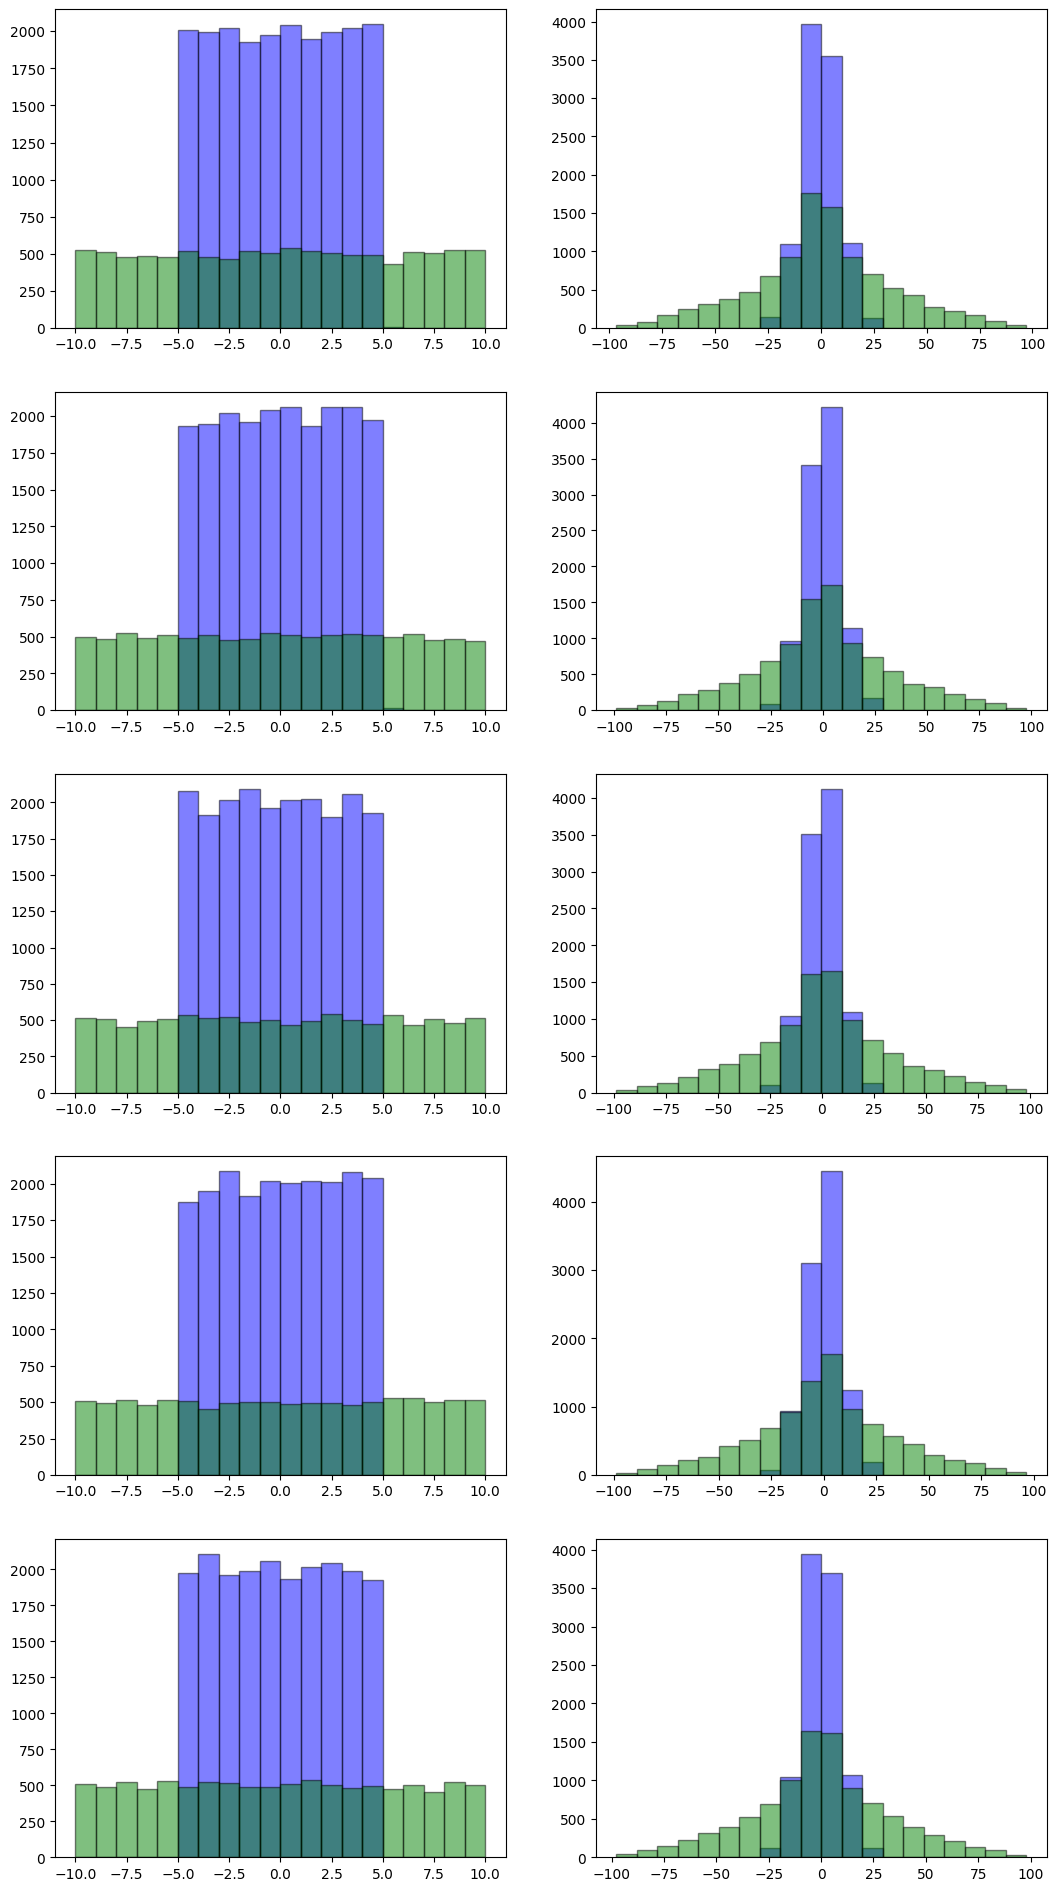

In [6]:
training_x, training_y =  MultiplicationDataset(n_points=n_points, length=10000, training=True)[:]
testing_x, testing_y =  MultiplicationDataset(n_points=n_points, length=10000, training=False)[:]

n_cols = 2
n_rows = n_points
fig = plt.figure(figsize=(n_cols*6.4, n_rows*4.8))
gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
for ii in range(n_points):    
    bin_edges = np.histogram_bin_edges(
        np.concatenate( (training_x[:,ii], training_x[:,n_points+ii], testing_x[:,ii]) ),
        bins=20
    )
    ax = fig.add_subplot(gs[ii,0])
    ax.hist(
        np.concatenate( (training_x[:,ii],training_x[:,ii]) ),
        bins=bin_edges, alpha=0.5, color="blue", edgecolor="black"
    )
    ax.hist(testing_x[:,ii], bins=bin_edges, alpha=0.5, color="green", edgecolor="black")
    
    bin_edges = np.histogram_bin_edges(
        np.concatenate( (training_y[:,ii], testing_y[:,ii]) ),
        bins=20
    )
    ax = fig.add_subplot(gs[ii,1])
    ax.hist(training_y[:,ii], bins=bin_edges, alpha=0.5, color="blue", edgecolor="black")
    ax.hist(testing_y[:,ii], bins=bin_edges, alpha=0.5, color="green", edgecolor="black")
plt.show()

# The Model

In [7]:
class MultiplicationCalculator(torch.nn.Module):
    def __init__(self, n_points, model="linear"):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        if model == "linear":
            self._model = self.encoder_ = torch.nn.Sequential(
                torch.nn.Linear(in_features=2*n_points, out_features=2*n_points, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(in_features=2*n_points, out_features=2*n_points, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(in_features=2*n_points, out_features=2*n_points, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(in_features=2*n_points, out_features=n_points, bias=True),
            )
        elif model == "bilinear":
            self._model = torch.nn.Bilinear(n_points, n_points, n_points, bias=True)
        else:
            raise ValueError(
                f"Invalid model type '{model}' specified. Expected one of ['linear', 'bilinear']."
            )
    
    def forward(self, X):
        if self.model == "linear":
            return self._model(X)
        else:
            X1, X2 = X[:, :self.n_points], X[:, self.n_points:]  # Split inputs
            return self._model(X1, X2)

# Callback Handlers

## `Callback`

In [8]:
class Callback:
    def on_train_begin(self, *args, **kwargs):
        pass

    def on_train_end(self, *args, **kwargs):
        pass

    def on_epoch_begin(self, *args, **kwargs):
        pass

    def on_epoch_end(self, *args, **kwargs):
        pass

    def on_mini_batch_begin(self, *args, **kwargs):
        pass

    def on_mini_batch_end(self, *args, **kwargs):
        pass

    @staticmethod
    def notify(callbacks, method_name, *args, **kwargs):
        for obj in callbacks:
            method = getattr(obj, method_name)
            method(*args, **kwargs)

## `LogPerformance`

In [9]:
class LogPerformance(Callback):
    def __init__(
        self,
        criterion,
        training_dataloader=None,
        validation_dataloader=None,
        device="cpu",
        warm_start=False
    ):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.loss = dict()

    def _get_gradient_norm(self, model):
        return np.sum(tuple(
            param.grad.norm().item()**2
            for name, param in model.named_parameters()
            if param.grad is not None
        ))**0.5
    
    def _get_performance(self, model, dataloader):
        n_samples = 0
        loss = torch.tensor(0., dtype=torch.float32).to(self.device)
        model.to(self.device).eval()
        for x_train,y_train in dataloader:
            n_samples += len(x_train)
            x_train, y_train = x_train.to(self.device), y_train.to(self.device)
            y_pred = model(x_train)
            loss += self.criterion(y_pred, y_train) * len(x_train) if self.criterion.reduction=="mean" else 1
        if self.criterion.reduction == "mean":
            loss /= n_samples
        return loss
    
    def _log_training_performance(self, model, loss_log):
        if self.training_dataloader is None:
            return
        loss = self._get_performance(model, self.training_dataloader)
        training_loss = loss_log.setdefault("training_loss", list())
        training_loss.append(loss.item())
        loss.backward()
        gradient_norm = loss_log.setdefault("gradient_norm", list())
        gradient_norm.append( self._get_gradient_norm(model) )

    def _log_validation_performance(self, model, loss_log):
        if self.validation_dataloader is None:
            return
        with torch.no_grad():
            loss = self._get_performance(model, self.validation_dataloader)
        validation_loss = loss_log.setdefault("validation_loss", list())
        validation_loss.append(loss.item())

    def _log_performance(self, model, loss_log):
        self._log_training_performance(model, loss_log)
        self._log_validation_performance(model, loss_log)

    def on_train_begin(self, n_epochs, model, logs, *args, **kwargs):
        if not self.warm_start:
            self.loss = dict()
        self._log_performance(model, self.loss)
        for key,value in self.loss.items():
            logs[key] = np.asarray(value)

    def on_epoch_begin(self, *args, **kwargs):
        mini_batch_loss = self.loss.setdefault("mini_batch_loss", list())
        mini_batch_loss.append(list())

    def on_epoch_end(self, model, logs, *args, **kwargs):
        self._log_performance(model, self.loss)
        for key,value in self.loss.items():
            logs[key] = np.asarray(value)

    def on_mini_batch_end(self, loss, logs, *args, **kwargs):
        mini_batch_loss = self.loss.setdefault("mini_batch_loss", list())
        mini_batch_loss[-1].append(loss)
        logs["mini_batch_loss"] = np.asarray(mini_batch_loss[-1])

## `PrintProgress`

In [10]:
# 1 final score
# 2 every 10th score
# 3 every 10th score + mini batch summary
# 4 every 10th score + mini batch mini details
# 5 every 10th score + mini batch all details
# 6 every score
# 7 every score + mini batch summary
# 8 every score + mini batch mini details
# 9 every score + mini batch all details

class PrintProgress(Callback):
    def __init__(self, verbose=0, verbose_epoch_mod=10, verbose_mini_batch_mod=10):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.logger = logging.getLogger("PrintProgress")
        if not self.logger.hasHandlers():
            self.logger.addHandler( logging.StreamHandler(sys.stdout) )
        self.logger.setLevel(logging.DEBUG-verbose)

    def _log_epoch_progress_helper(self, epoch, n_epochs, logs, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        # training performance
        training_loss = logs.get("training_loss", [np.nan])[-1]
        # validation performance
        validation_loss = logs.get("validation_loss", [np.nan])[-1]
        # message
        message = (
            f"Epoch: {epoch:>{n_epochs_digits}d}/{n_epochs} ({epoch/n_epochs*100:6.2f}%)   "
            f"Training Loss: {training_loss:.6f}   Validation Loss: {validation_loss:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_epoch_progress(self, epoch, n_epochs, logs):
        if epoch == n_epochs:
            message_level = 1
        elif epoch == 0 or epoch % self.verbose_epoch_mod == 0:
            message_level = 2
        else:
            message_level = 6
        self._log_epoch_progress_helper(epoch, n_epochs, logs, message_level)

    def _log_mini_batch_progress_helper(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        n_mini_batch_digits = int(np.log10(n_batches)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}  "
            f"[{mini_batch:>{n_mini_batch_digits}d}/{n_batches}  ({mini_batch/n_batches*100:3.0f}%)]   "
            f"Loss: {loss:15.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_summary(self, epoch, n_epochs, logs, message_level):
        mini_batch_loss = logs["mini_batch_loss"]
        mean, std = np.mean(mini_batch_loss), np.std(mini_batch_loss)
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}   "
            f"Mini Batch Average Loss: {mean:.6f} +/- {std:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_progress(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, logs):
        if epoch == n_epochs or epoch % self.verbose_epoch_mod == 0:
            message_level = 4 if mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches else 5
            message_level += 4 if self.verbose >= 6 else 0
        elif mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches:
            message_level = 8
        else:
            message_level = 9
        self._log_mini_batch_progress_helper(epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level)
        if mini_batch == n_batches:
            if epoch % self.verbose_epoch_mod == 0 or epoch == n_epochs:
                message_level = 3
                message_level += 4 if self.verbose >= 6 else 0
            else:
                message_level = 7
            self._log_mini_batch_summary(epoch, n_epochs, logs, message_level)

    def on_train_begin(self, n_epochs, model, logs, *args, **kwargs):
        self.n_epochs = n_epochs
        self._log_epoch_progress(0, self.n_epochs, logs)

    def on_epoch_end(self, epoch, model, logs, *args, **kwargs):
        self._log_epoch_progress(epoch, self.n_epochs, logs)

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, logs, *args, **kwargs):
        self._log_mini_batch_progress(epoch, self.n_epochs, mini_batch, n_batches, batch_size, loss, logs)

## `PlotProgress`

The `PlotProgress` callback handler serves to visualize the loss and accuracy of the network across epochs and mini-batches. Additionally, it generates plots displaying sample digits and their predictions. Note that this handler requires the invocation of the `LogPerformance` handler to ensure accurate data for plotting.

In [11]:
class PlotProgress(Callback):
    def __init__(
        self,
        limit_loss,
        device
    ):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def _plot_loss(self, ax, training_loss, validation_loss, limit):
        epochs = None
        if training_loss is not None:
            epochs = np.arange(len(training_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], training_loss[-limit:], marker=marker, label="Traning Loss")
        if validation_loss is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], validation_loss[-limit:], marker=marker, label="Validation Loss")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("MSE Loss")
            ax.legend()

    @torch.no_grad()
    def _plot_results(self, epoch, training_loss, validation_loss, model):
        if epoch % self.limit_loss == 0:
            clear_output(wait=True)
            n_rows = 1
            n_cols = 2
            fig = plt.figure(figsize=(n_cols*6.4, n_rows*4.8))
            gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
            
            self._plot_loss(fig.add_subplot(gs[0,0]), training_loss, validation_loss, -1)
            self._plot_loss(fig.add_subplot(gs[0,1]), training_loss, validation_loss, self.limit_loss)
            
            fig.suptitle(f"Iteration {epoch}", x=(fig.subplotpars.right + fig.subplotpars.left)/2, y=1.001)
            fig.tight_layout()
            plt.show()

    def on_train_begin(self, n_epochs, model, logs, *args, **kwargs):
        self._plot_results(
            0,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            model
        )

    def on_epoch_end(self, epoch, model, logs, *args, **kwargs):
        self._plot_results(
            epoch,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            model
        )

# Traning

## Training Loop

The `train_model` function implements a standard training loop for a neural network. It performs `n_epochs` iterations of the following steps:
- In each epoch, the training data is split into mini-batches using the `dataloader`.
- For each mini-batch, the loop performs forward and backward passes through the `model`, using the `criterion` to compute the loss and the `optimizer` to update the model parameters.

The training loop allows for the integration of various callback handlers, facilitating monitoring and logging of training progress. A dictionary, `logs`, is used to store training logs generated by these callback handlers:
- Before training begins, registered callbacks are notified by calling `on_train_begin` with `n_epochs`, `model`, and `logs` as arguments.
- Before each mini-batch, registered callbacks are notified by calling `on_mini_batch_begin` with `mini_batch`, `n_batches`, `batch_size`, `epoch`, `n_epochs`, `model`, and `logs` as arguments.
- After each mini-batch, registered callbacks are notified by calling `on_mini_batch_end` with `mini_batch`, `n_batches`, `batch_size`, `epoch`, `n_epochs`, `loss`, `model`, and `logs` as arguments.
- At the end of each epoch, registered callbacks are notified by calling `on_epoch_end` with `epoch`, `n_epochs`, `model`, and `logs` as arguments.
- Once training is complete, registered callbacks are notified by calling `on_train_end` with `model` and `logs` as arguments.

In [12]:
def time_function(msg="Elapsed Time:"):
    import time
    from datetime import timedelta
    def real_timing_function(function):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            res = function(*args, **kwargs)
            elapsed = time.time() - start_time
            print(msg, timedelta(seconds=elapsed))
            return res
        return wrapper
    return real_timing_function

@time_function("Training Time:")
def train_model(
    model,
    device,
    dataloader,
    criterion,
    optimizer,
    n_epochs,
    callbacks=None,
    logs=None
):
    if callbacks is None:
        callbacks = list()
    if logs is None:
        logs = dict()
    
    # notify each callback of the beginning of training
    Callback.notify(
        callbacks, "on_train_begin",
        n_epochs=n_epochs, model=model, logs=logs
    )
    
    for epoch in range(1,n_epochs+1):
        # notify each callback of the beginning of the epoch
        Callback.notify(
            callbacks, "on_epoch_begin",
            epoch=epoch, n_epochs=n_epochs, model=model, logs=logs
        )
        for mini_batch,(x_train,y_train) in enumerate(dataloader, 1):
            # notify each callback of the mini batch
            Callback.notify(
                callbacks, "on_mini_batch_begin",
                mini_batch=mini_batch, n_batches=len(dataloader), batch_size=len(x_train),
                epoch=epoch, n_epochs=n_epochs, model=model, logs=logs
            )
            
            # zero out the generator gradients
            optimizer.zero_grad()
            model.to(device).train()

            # pass the data through the model and compute the loss
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            # compute the gradients and update the model's weights
            loss.backward()
            optimizer.step()
    
            # notify each callback of the mini batch
            Callback.notify(
                callbacks, "on_mini_batch_end",
                mini_batch=mini_batch, n_batches=len(dataloader), batch_size=len(x_train),
                epoch=epoch, n_epochs=n_epochs,
                loss=loss.item(), model=model, logs=logs
            )
        
        # notify each callback of the end of the epoch
        Callback.notify(
            callbacks, "on_epoch_end",
            epoch=epoch, n_epochs=n_epochs, model=model, logs=logs
        )

    # notify each callback of the end of training
    Callback.notify(
        callbacks, "on_train_end",
        model=model, logs=logs
    )

## Training Parameters

In [13]:
n_epochs = 500
batch_size = 32
shuffle = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mse_loss = torch.nn.MSELoss(reduction="mean")

calculator = MultiplicationCalculator(n_points=n_points, model="bilinear")
adam_optimizer = torch.optim.Adam(calculator.parameters())

print(device)
print(calculator)

cpu
MultiplicationCalculator(
  (_model): Bilinear(in1_features=5, in2_features=5, out_features=5, bias=True)
)


## Data Loaders

In [14]:
training_dataloader = torch.utils.data.DataLoader(
    NumpyToTensorDataset(MultiplicationDataset(n_points=n_points, length=n_samples, training=True)),
    batch_size=batch_size,
    shuffle=shuffle,
)

## Initialize Callbacks

Here we initialize the callback objects and add them to the `callbacks` list. To reduce the computation required to log the training and validation loss between each epoch, a subset of size $500=50\cdot10$ from their respective datasets is utilize.

In [15]:
log_performance = LogPerformance(
    criterion=mse_loss,
    training_dataloader=torch.utils.data.DataLoader(
        NumpyToTensorDataset(MultiplicationDataset(n_points=n_points, length=100, training=True)),
        batch_size=100,
        shuffle=shuffle,
    ),
    validation_dataloader=torch.utils.data.DataLoader(
        NumpyToTensorDataset(MultiplicationDataset(n_points=n_points, length=100, training=True)),
        batch_size=100,
        shuffle=shuffle,
    ),
    device=device
)

print_progress = PrintProgress(
    verbose=2,
    verbose_epoch_mod=10
)

plot_progress = PlotProgress(
    limit_loss=200,
    device=device
)

callbacks = [log_performance, print_progress, plot_progress]

## Train the Model

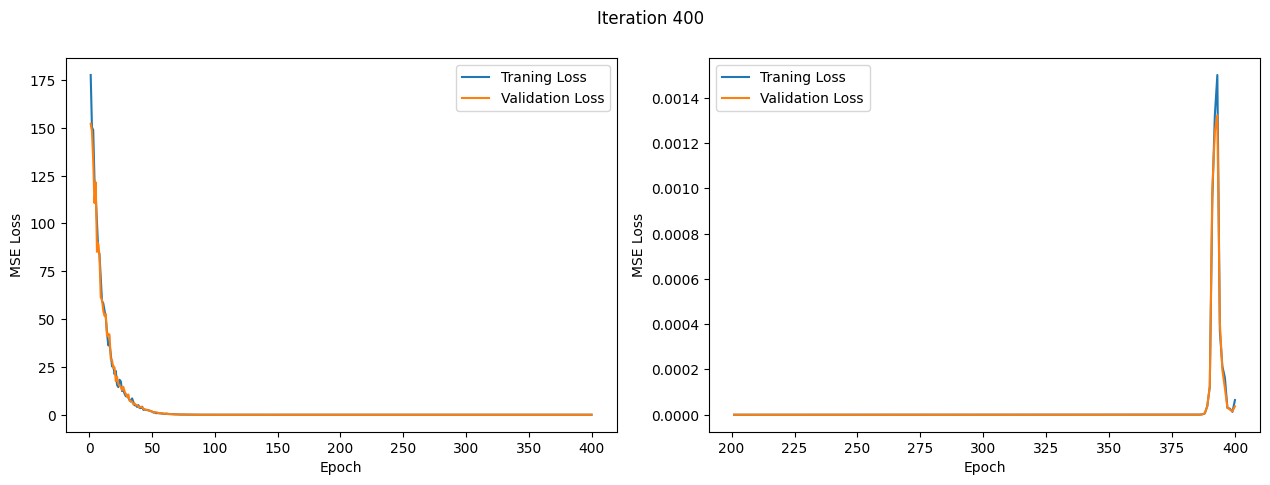

Epoch: 410/500 ( 82.00%)   Training Loss: 0.000034   Validation Loss: 0.000026
Epoch: 420/500 ( 84.00%)   Training Loss: 0.000100   Validation Loss: 0.000104
Epoch: 430/500 ( 86.00%)   Training Loss: 0.000279   Validation Loss: 0.000382
Epoch: 440/500 ( 88.00%)   Training Loss: 0.000314   Validation Loss: 0.000273
Epoch: 450/500 ( 90.00%)   Training Loss: 0.000010   Validation Loss: 0.000013
Epoch: 460/500 ( 92.00%)   Training Loss: 0.000100   Validation Loss: 0.000121
Epoch: 470/500 ( 94.00%)   Training Loss: 0.000462   Validation Loss: 0.000530
Epoch: 480/500 ( 96.00%)   Training Loss: 0.000722   Validation Loss: 0.000591
Epoch: 490/500 ( 98.00%)   Training Loss: 0.000121   Validation Loss: 0.000117
Epoch: 500/500 (100.00%)   Training Loss: 0.000562   Validation Loss: 0.000517
Training Time: 0:00:30.730445


In [16]:
logs = dict()
train_model(
    model=calculator,
    device=device,
    dataloader=training_dataloader,
    criterion=mse_loss,
    optimizer=adam_optimizer,
    n_epochs=n_epochs,
    callbacks=callbacks,
    logs=logs
)

# Test

xx: (9, 10)
yy: (9, 5)
xa: (9, 5)
xb: (9, 5)


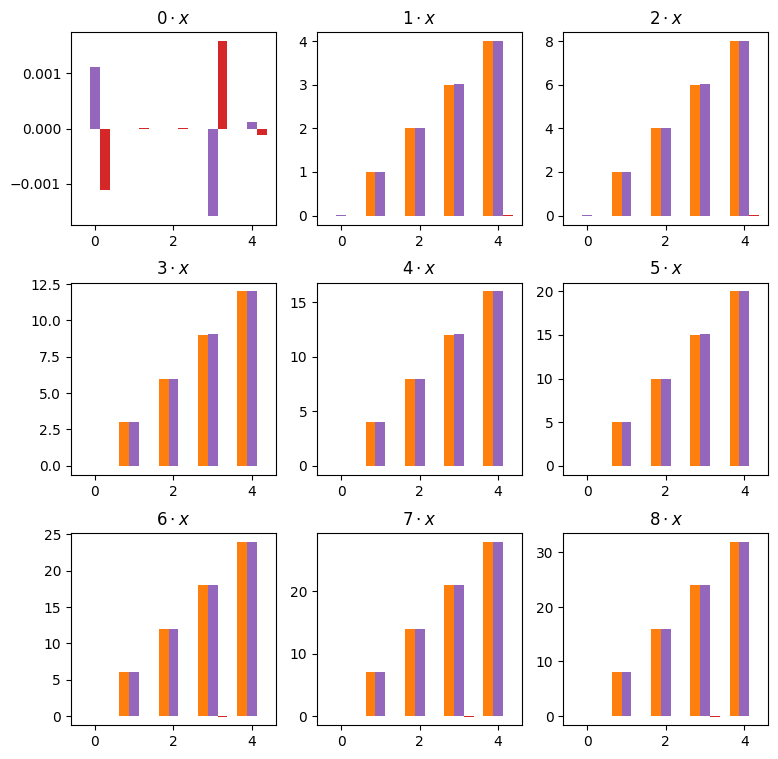

In [17]:
xx = np.array(tuple(
    np.concatenate(
        (np.full(shape=5, fill_value=ii), np.arange(0,n_points))
    )
    for ii in range(9)
))
xa, xb = xx[:,:n_points], xx[:,n_points:]
yy = xa * xb

print(f"xx: {xx.shape}")
print(f"yy: {yy.shape}")
print(f"xa: {xa.shape}")
print(f"xb: {xb.shape}")

with torch.no_grad():
    inputs = torch.from_numpy(xx.astype(np.float32)).to(device)
    y_pred = calculator(inputs).to("cpu").numpy()

indices = np.arange(n_points)
width = 1/4

n_cols = 3
n_rows = int( np.ceil(len(yy)/n_cols) )
fig = plt.figure(figsize=(n_cols*3, n_rows*3))
gs = mpl.gridspec.GridSpec(
    nrows=n_rows, ncols=n_cols, hspace=0.3, figure=fig
)

for ii in range(len(yy)):
    error = yy[ii]-y_pred[ii]
    ax = fig.add_subplot(gs[ii])
    ax.bar(indices - width, yy[ii],     width=width, color="tab:orange", label="C")
    ax.bar(indices,         y_pred[ii], width=width, color="tab:purple", label="$\\hat{C}$")
    ax.bar(indices + width, error,      width=width, color="tab:red",    label="Risidual")
    ax.set_title(f"${ii}\cdot x$")
plt.show()

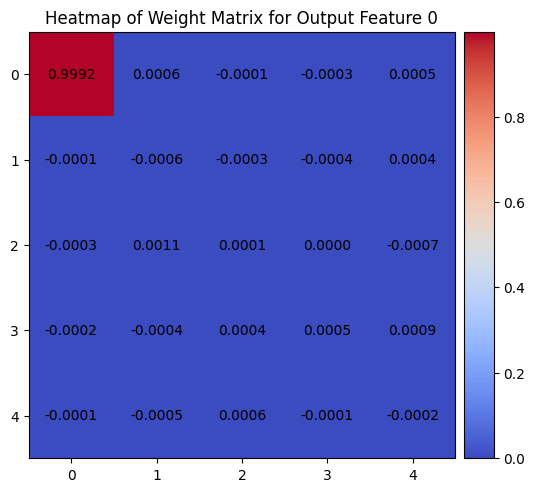

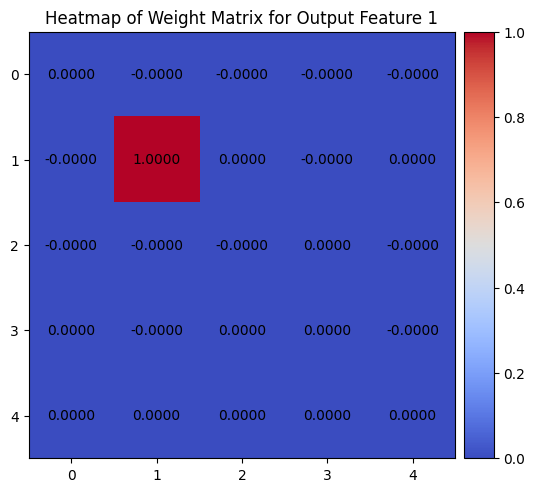

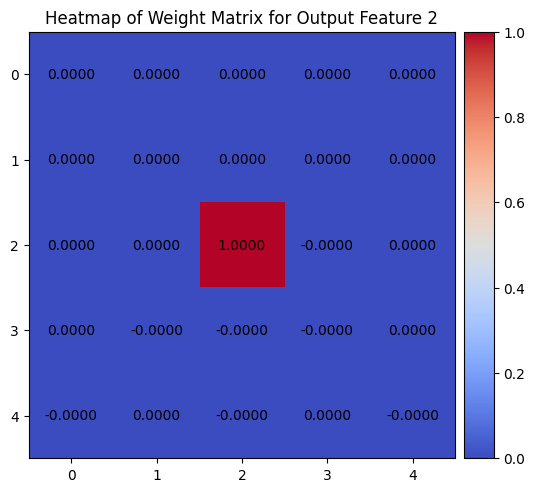

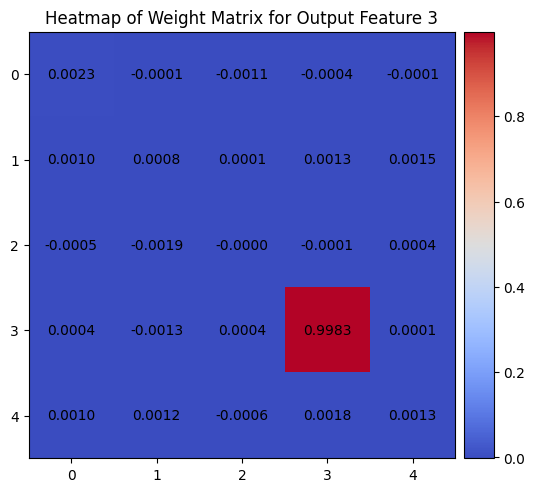

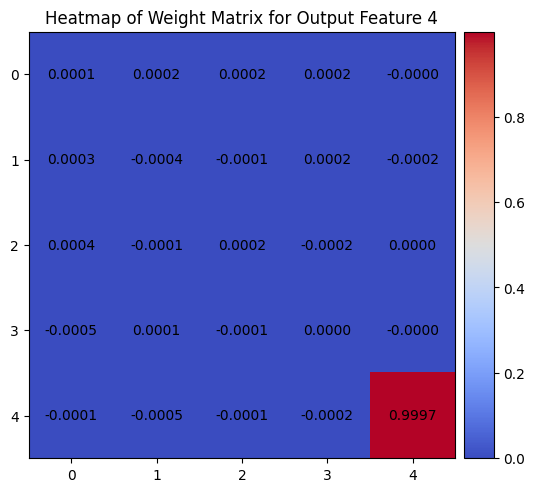

In [18]:
if calculator.model == "bilinear":
    weights = calculator._model.weight.detach().cpu().numpy()

    for i, W_i in enumerate(weights):
        fig,ax = plt.subplots(figsize=(6, 6))
        img = ax.imshow(W_i, cmap="coolwarm")
        for (jj, kk), val in np.ndenumerate(W_i):
            ax.text(kk, jj, f'{val:.4f}', ha="center", va="center", color="black")

        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="7%", pad="2%")
        fig.colorbar(img, cax=cax)
        ax.set_title(f"Heatmap of Weight Matrix for Output Feature {i}")
        plt.show()